# Machine Learning with Turbulent Simulations

In [163]:
%matplotlib inline
import pandas as pd
import numpy as np
from matplotlib import pyplot as plt
import matplotlib.image as mpimg
import seaborn as sns
sns.set_style("whitegrid", {'axes.grid' : False})
from sklearn.cross_validation import train_test_split
from sklearn.metrics import r2_score
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor
import os
import re

from dataimport import ImportData

In [172]:
def normalize(x):
    """
    Normalize a list of sample image data in the range of 0 to 1
    : x: List of image data.  The image shape is (32, 32, 3)
    : return: Numpy array of normalize data
    """
    x = (x-np.min(x))/(np.max(x)-np.min(x))
    # TODO: Implement Function
    return x

In [164]:
def ImportData(folder):
    file_list = []
    file_list.append(pd.read_table('./Mesh/meshcoord.txt',sep="\s+"))
    for filename in os.listdir(folder):
        if filename.endswith(".txt"): 
            file_list.append(pd.read_csv(os.path.join(folder, filename),sep="\s+"))
    df = pd.DataFrame()
    df = pd.concat(file_list,axis=1)
    df = df.drop(['vz','v','ccz'],axis=1)
    variables = {}
    for col in df.columns:
        variables[col],ccx,ccy = np.histogram2d(df.ccx,df.ccy,weights=df[col],bins=(225,200))
        variables[col] = np.vstack((np.zeros(200),variables[col],np.zeros(200)))
        variables[col] = np.hstack((np.zeros((227,1)),variables[col],np.zeros((227,1))))
        variables[col] = variables[col].T[::-1]
        
    o = np.zeros((225,200))
    xg, yg = np.meshgrid(np.arange(100,125,1),np.arange(0,50,1))
    for i in np.arange(100,125,1):
        for j in np.arange(0,50,1):
            o[i,j] = 1
    variables['o'] = o
    variables['o'] = np.vstack((np.ones(200)+5,variables['o'],np.ones(200)+2))
    variables['o'] = np.hstack((np.ones((227,1)),variables['o'],np.ones((227,1))))
    variables['o'] = variables['o'].T[::-1]
    
    dataconv = variables.copy()
    
    variables.pop('ccx',None)
    variables.pop('ccy',None)
    
    plist = []
    for i in np.arange(1,201,1):
        for j in np.arange(1,226,1):
            di = {}
            for col in variables:
                di.update({col+'in':variables[col][i,j],col+'right':variables[col][i,j-1],
                              col+'left':variables[col][i,j+1],col+'up':variables[col][i-1,j],
                              col+'down':variables[col][i+1,j]})
                di.update({'ccx':ccx[j-1],'ccy':ccy[-i]})
            plist.append(di)
    data= pd.DataFrame(plist)
    
    return data,dataconv


In [261]:
folder = os.getcwd()+'/OpenFOAMfiles/turbulent/machineRANS/0.1'
datarans1,_ = ImportData(folder)
folder = os.getcwd()+'/OpenFOAMfiles/turbulent/machineRANS/0.15'
datarans15,_ = ImportData(folder)
folder = os.getcwd()+'/OpenFOAMfiles/turbulent/machineRANS/0.05'
datarans05,_ = ImportData(folder)
folder = os.getcwd()+'/OpenFOAMfiles/turbulent/machineLES/0.05'
datales05,_ = ImportData(folder)
folder = os.getcwd()+'/OpenFOAMfiles/turbulent/machineLES/0.1'
datales1,_ = ImportData(folder)
folder = os.getcwd()+'/OpenFOAMfiles/turbulent/machineLES/0.15'
datales15,_ = ImportData(folder)

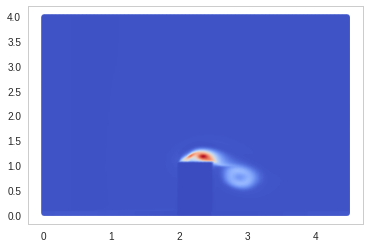

In [262]:
plt.scatter(datarans1.ccx,datarans1.ccy,c=datarans1.nutin,s=20.,cmap='coolwarm')

In [283]:
datainput  = pd.concat([datarans05,datarans1,datarans15],ignore_index=True)
dataoutput = pd.concat([datales05,datales1,datales15],ignore_index=True)

In [284]:
datainput  = datainput.drop(['ccx','ccy'],axis=1).copy()
dataoutput = dataoutput.pressurein.copy()
datainput = normalize(datainput)
dataoutput= normalize(dataoutput)

In [285]:
clf = RandomForestRegressor(random_state=52,n_estimators=20)
# clf = DecisionTreeRegressor(random_state=52)
clf = clf.fit(datainput,dataoutput)

In [286]:
r2_score(dataoutput,clf.predict(datainput))

0.99802879054049221

In [294]:
folder = os.getcwd()+'/OpenFOAMfiles/turbulent/machineRANS/0.2'
datarans2,_ = ImportData(folder)
folder = os.getcwd()+'/OpenFOAMfiles/turbulent/machineLES/0.2'
datales2,_ = ImportData(folder)

In [295]:
datainput  = datarans2.drop(['ccx','ccy'],axis=1).copy()
dataoutput = datales2.pressurein.copy()
dataoutput = normalize(datainput)
dataoutput = normalize(dataoutput)

In [296]:
r2_score(dataoutput,clf.predict(datainput))

ValueError: y_true and y_pred have different number of output (35!=1)

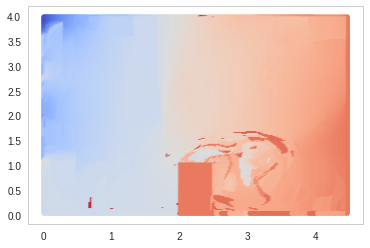

In [282]:
plt.scatter(datarans1.ccx,datarans1.ccy,c=clf.predict(datarans2.drop(['ccx','ccy'],axis=1)),s=20.,cmap='coolwarm')
# plt.scatter(datarans1.ccx,datarans1.ccy,c=datarans2.pressurein,s=20.,cmap='coolwarm')

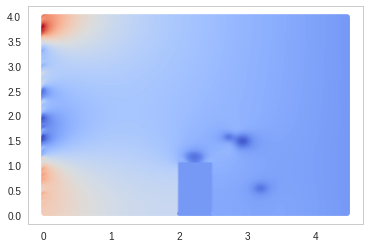

In [272]:
plt.scatter(datarans1.ccx,datarans1.ccy,c=datales2.pressurein,s=20.,cmap='coolwarm')